In [128]:
from sentence_transformers import SentenceTransformer, util
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


## Exploration
try it on some dummy sentences

Sentence embeddings:
(6, 384)


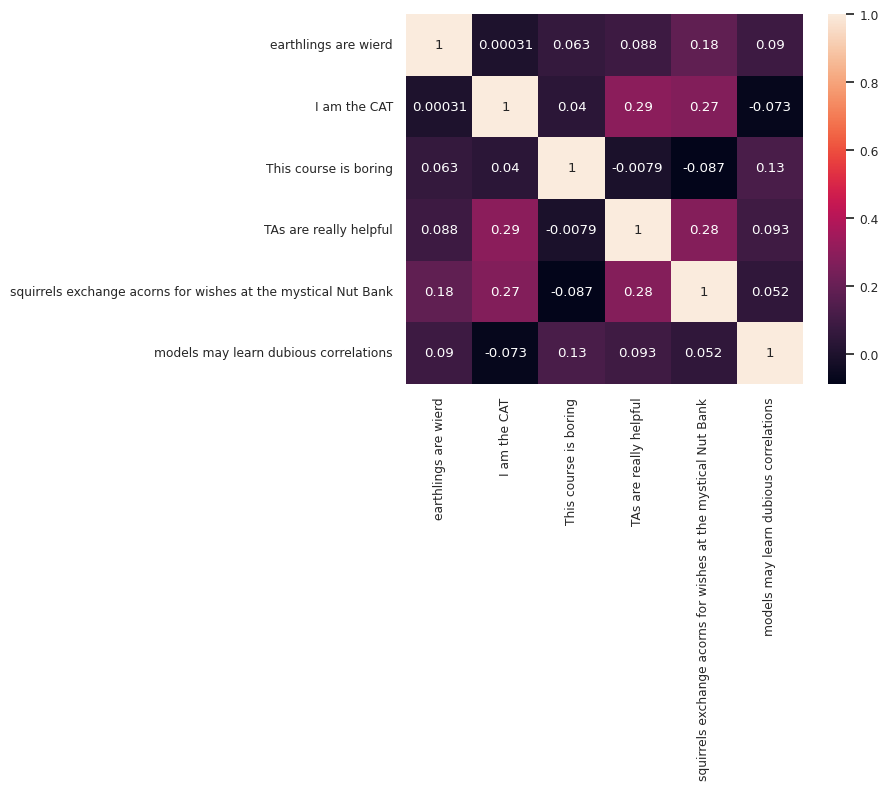

In [414]:
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

sentences = ["earthlings are wierd",
            "I am the CAT",
            "This course is boring",
            "TAs are really helpful",
            "squirrels exchange acorns for wishes at the mystical Nut Bank",
            "models may learn dubious correlations",
]
sentence_embeddings = model.encode(sentences)

print("Sentence embeddings:")
print(sentence_embeddings.shape)
sim_mat = util.pytorch_cos_sim(sentence_embeddings, sentence_embeddings)

#plotting the similarity matrix

sns.set(font_scale=0.8)
sns.heatmap(sim_mat, annot=True, xticklabels=sentences, yticklabels=sentences)
plt.show()



## using it on dev_set data

### functions

In [190]:
from tqdm import tqdm
import torch
import json
import os
import math
import matplotlib.pyplot as plt
import seaborn as sns


In [97]:

class Dataset:
    """ 
    gives preprocessed data suitable for giving to the SBERT model
    """
    def __init__(self,
                  file_path='data/train.json',
                  debug_level=0):
        
        self.df = pd.read_json(file_path)
        self.df = self.df.transpose()
        self.CTs_path = 'data/CTs/'

        self.debug_level = debug_level
    
    def __len__(self):
        return len(self.df)
    
    def extract_section(self,CTR_id, section_id):

        if type(CTR_id) != str and math.isnan(CTR_id):
            if self.debug_level > 0:
                print('CTR_id is nan')
            return []
        file_path = os.path.join(self.CTs_path, CTR_id + '.json')
        with open(file_path) as f:
            data = json.load(f)
            CTR = data[section_id]
        return CTR
    
    def __getitem__(self, idx):
        sample = self.df.iloc[idx]
        section_id = sample['Section_id']
        statement = sample['Statement']
        primary_id = sample['Primary_id']
        secondary_id = sample['Secondary_id']
        primary_evidence_index = sample['Primary_evidence_index']
        secondary_evidence_index = sample['Secondary_evidence_index']

        dataset = Dataset()
        CTR_1 = dataset.extract_section(primary_id, section_id)
        CTR_2 = dataset.extract_section(secondary_id, section_id)

        primary_evidence_index_binary = [1 if i in primary_evidence_index else 0 for i in range(len(CTR_1))]
        secondary_evidence_index_binary = [1 if i in secondary_evidence_index else 0 for i in range(len(CTR_2))]
                                           
        
        return {
            "statement": statement,
            "sentences": CTR_1 + CTR_2,
            "lengths": [ len(CTR_1), len(CTR_2)],
            "labels": primary_evidence_index_binary+ secondary_evidence_index_binary,
            "_label_index": [primary_evidence_index, secondary_evidence_index]
        }
    
    def __iter__(self):
        for i in range(len(self)):
            yield self[i]

In [234]:


def calculate_similarity(dataset,
                        model,
                        device='cuda', 
                        club_across_samples=False,
                        score_function='cosine_similarity'):
    """
    calculates the similarity between the statement and the sentences for each sample in the dataset. 

    club_across_samples: if True, the sims and labels are clubbed across samples. so, returns list, instead of list of lists.
    return:
    sims: list of list of sims 
    labels: list of list of labels 

    both are of shape (num_samples, num_sentences in ctr1 + num_sentences in ctr2 for that particular sample)
    sentences of ctr1 are first followed by sentences of ctr2 (mixed into one list).
    """
    sims = []
    labels = []

    model.to(device)
    model.eval()

    for i in tqdm(range(len(dataset))):
    # for i in range(10):
        sample = dataset[i]
        statement = sample['statement']
        sentences = sample['sentences']

        inputs = [statement] + sentences
        sample_embeddings = model.encode(inputs)
        # sim = util.pytorch_cos_sim(sample_embeddings[0], sample_embeddings[1:])[0].tolist()
        if score_function == 'cosine_similarity':
            sim = util.pytorch_cos_sim(sample_embeddings[0], sample_embeddings[1:])[0].tolist()
        elif score_function == 'dot_product':
            sim = util.dot_score(sample_embeddings[0], sample_embeddings[1:])[0].tolist()
        else:
            raise ValueError('score_function should be either cosine_similarity or dot_product')

        sims.append(sim)
        labels.append(sample['labels'])

    if club_across_samples:
        sims = np.concatenate(sims)
        labels = np.concatenate(labels)


    return sims, labels



In [382]:

def plot_similarities(sim, labels,fig_size=(5,5)):
    """ 
    plots the histogram of similarities for true and false samples
    """
    true_sim = []
    false_sim = []
    for i, label in enumerate(labels):

        if label:
            true_sim.append(sim[i])
        else:
            false_sim.append(sim[i])

    plt.figure(figsize=fig_size)
    plt.hist(true_sim, bins=30, alpha=0.5, label='true')
    plt.hist(false_sim, bins=30, alpha=0.5, label='false')
    plt.legend(loc='upper right')
    plt.show()

In [390]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, auc

def plot_roc_curve(y_true, y_score,fig_size=(5,5)):
    
    fpr, tpr, thresholds = roc_curve(y_true, y_score, pos_label=1)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=fig_size)
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

    return roc_auc, fpr, tpr, thresholds


In [384]:
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

def calculate_metrics(sims, labels, thresholds,tpr, fpr):
    best_threshold = thresholds[np.argmax(tpr - fpr)]
    y_pred = [1 if sim > best_threshold else 0 for sim in sims]
    y_true = labels

    f1 = f1_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)

    print(f"""
    best_threshold: {round(best_threshold, 4)} 
        
    f1: {round(f1, 4)}
    accuracy: {round(accuracy, 4)}
    precision: {round(precision, 4)}
    recall: {round(recall, 4)}""")


### running

In [402]:
def run_with_model(model_name ="paraphrase-MiniLM-L6-v2",
                     file_path='data/dev.json',
                     device='cuda',
                     score_function='cosine_similarity',
                        fig_size=(5,4)
):
    dataset = Dataset(file_path = file_path)
    if type(model_name) == str:
        model = SentenceTransformer(model_name)
    else:
        model = model_name
        print('using the given model')
    sims, labels = calculate_similarity(dataset, model, device= device, club_across_samples=True,
                                        score_function = score_function)
    plot_similarities(sims, labels, fig_size=fig_size)
    roc_auc, fpr, tpr, thresholds = plot_roc_curve(labels, sims, fig_size=fig_size)
    calculate_metrics(sims, labels, thresholds, tpr, fpr)
    


#### Try different models with different score_functions

 

 =================== cosine_similarity ===================== 




100%|██████████| 200/200 [00:52<00:00,  3.84it/s]


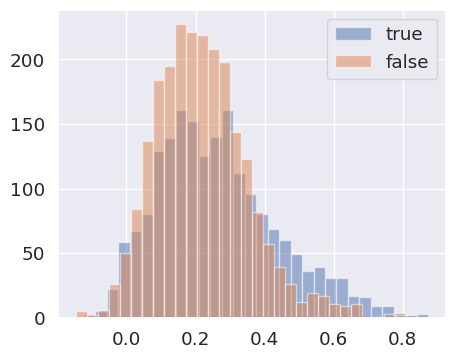

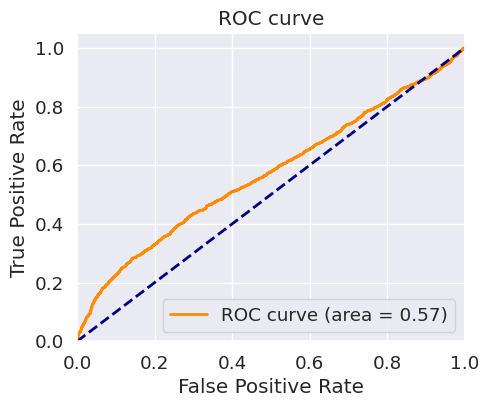


    best_threshold: 0.3489 
        
    f1: 0.3871
    accuracy: 0.5982
    precision: 0.6211
    recall: 0.2812
 

 =================== dot_product ===================== 




100%|██████████| 200/200 [00:52<00:00,  3.80it/s]


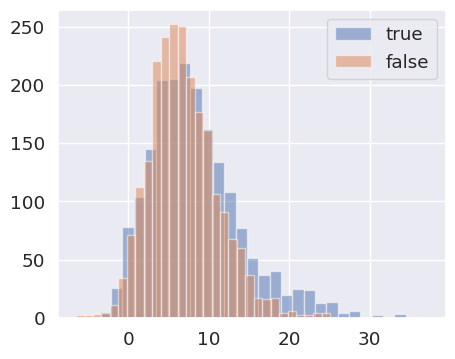

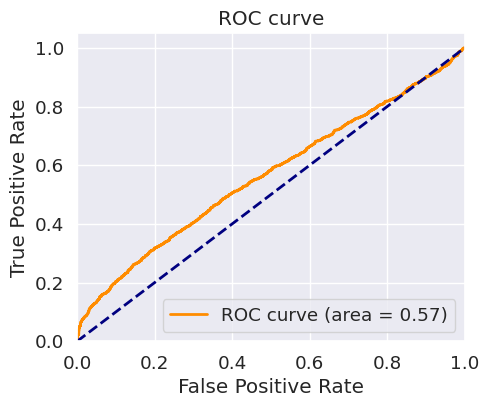


    best_threshold: 10.3551 
        
    f1: 0.3985
    accuracy: 0.584
    precision: 0.5734
    recall: 0.3054


In [403]:
MODEL_NAME = 'paraphrase-MiniLM-L6-v2'


print(" \n\n =================== cosine_similarity ===================== \n\n")
SCORE_FUNCTION = 'cosine_similarity'

run_with_model(model_name = MODEL_NAME,
                     file_path='data/dev.json',
                        device='cuda',
                        score_function = SCORE_FUNCTION)

print(" \n\n =================== dot_product ===================== \n\n")

SCORE_FUNCTION = 'dot_product'
run_with_model(model_name = MODEL_NAME,
                     file_path='data/dev.json',
                        device='cuda',
                        score_function = SCORE_FUNCTION)

Really not that helpful :(

### Try few more model

search for pretrained models on : https://www.sbert.net/docs/pretrained_models.html   
the suitable score fxn, pooling type etc. are also given.

#### "multi-qa-mpnet-base-dot-v1"  
recommended : dot_product

 

 =================== cosine_similarity ===================== 




100%|██████████| 200/200 [00:55<00:00,  3.63it/s]


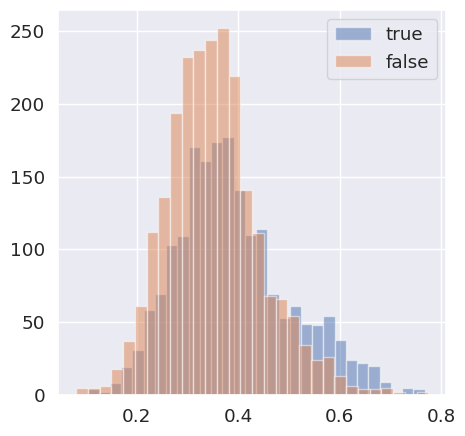

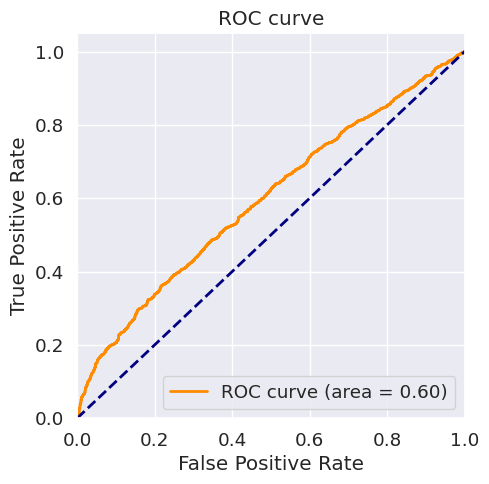


    best_threshold: 0.4117 
        
    f1: 0.4451
    accuracy: 0.5921
    precision: 0.5763
    recall: 0.3625
 

 =================== dot_product ===================== 




100%|██████████| 200/200 [00:54<00:00,  3.66it/s]


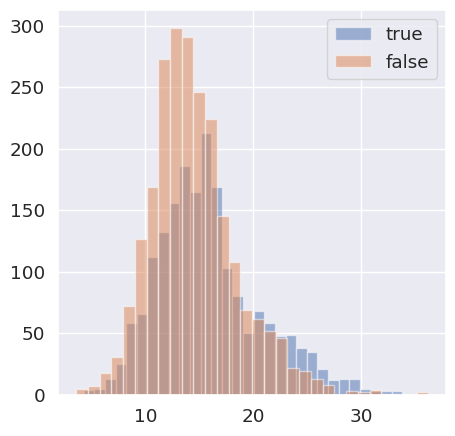

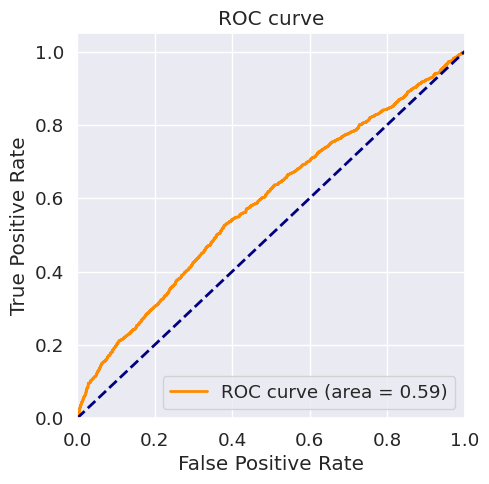


    best_threshold: 15.0231 
        
    f1: 0.5293
    accuracy: 0.5777
    precision: 0.5324
    recall: 0.5262


In [396]:
# model_name = "multi-qa-mpnet-base-dot-v1"
MODEL_NAME = 'multi-qa-mpnet-base-dot-v1'


print(" \n\n =================== cosine_similarity ===================== \n\n")
SCORE_FUNCTION = 'cosine_similarity'

run_with_model(model_name = MODEL_NAME,
                     file_path='data/dev.json',
                        device='cuda',
                        score_function = SCORE_FUNCTION)

print(" \n\n =================== dot_product ===================== \n\n")

SCORE_FUNCTION = 'dot_product'
run_with_model(model_name = MODEL_NAME,
                     file_path='data/dev.json',
                        device='cuda',
                        score_function = SCORE_FUNCTION)



#### "all-mpnet-base-v2" 
recommended score fxns: all three ( dot,cosine,euclidean)

 

 =================== cosine_similarity ===================== 




100%|██████████| 200/200 [00:55<00:00,  3.62it/s]


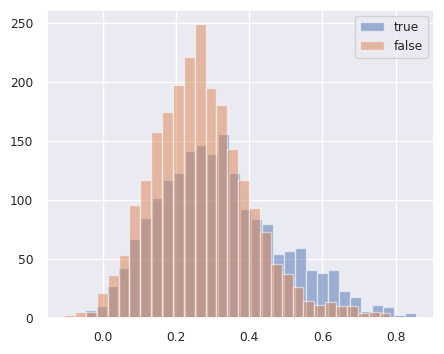

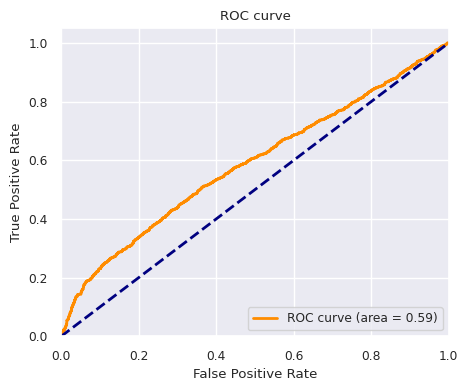


    best_threshold: 0.3283 
        
    f1: 0.4836
    accuracy: 0.5864
    precision: 0.5538
    recall: 0.4292
 

 =================== dot_product ===================== 




100%|██████████| 200/200 [00:55<00:00,  3.58it/s]


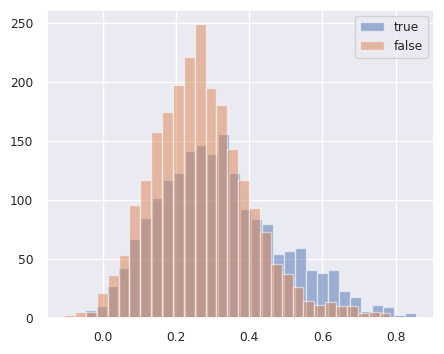

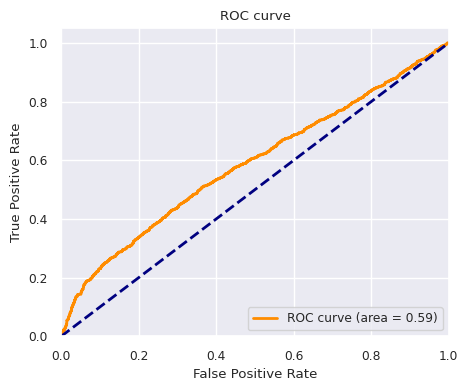


    best_threshold: 0.3283 
        
    f1: 0.4836
    accuracy: 0.5864
    precision: 0.5538
    recall: 0.4292


In [415]:
MODEL_NAME = "all-mpnet-base-v2"


print(" \n\n =================== cosine_similarity ===================== \n\n")
SCORE_FUNCTION = 'cosine_similarity'

run_with_model(model_name = MODEL_NAME,
                     file_path='data/dev.json',
                        device='cuda',
                        score_function = SCORE_FUNCTION)

print(" \n\n =================== dot_product ===================== \n\n")

SCORE_FUNCTION = 'dot_product'
run_with_model(model_name = MODEL_NAME,
                     file_path='data/dev.json',
                        device='cuda',
                        score_function = SCORE_FUNCTION)



### use ClinicalBERT ( with averaged embeddings)

get the sentence embedding, in 3 ways( cls, mean, max). see how bad are the results without any finetuning

In [416]:
class Model_wrapper_to_bert:
    """ 
    Just a wrapper around the BERT model to make it compatible with the above functions
    """
    def __init__(self,
                 tokenizer=None,
                 bert_model= None,
                 device="cpu",
                 pooling_type="mean"):
        self.tokenizer = tokenizer
        self.bert_model = bert_model

        self.device = device
        self.pooling_type = pooling_type

        self.to(device)
        self.eval()

    def encode(self,inputs):
        """ 
        inputs : list of strings (sentences)
        
        returns: 
            sentence embedding
        """
        tokenized_inputs = self.tokenizer(inputs,return_tensors="pt",padding=True).to(self.device)
        outputs = self.bert_model(**tokenized_inputs)

        if self.pooling_type == "mean":
            sentence_emb = outputs.last_hidden_state.mean(dim=1)
        elif self.pooling_type == "max":
            sentence_emb,_ = outputs.last_hidden_state.max(dim=1) # returns both max value and max value index
            # print(sentence_emb.shape) 
        elif self.pooling_type == "cls":
            sentence_emb = outputs.last_hidden_state[:,0]
        else:
            raise ValueError("pooling_type should be either mean, max or cls")

        return sentence_emb
    
    def to(self, device):
        self.device = device
        self.bert_model.to(device)
        return
    def eval(self):
        self.bert_model.eval()
        return
    


In [417]:
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("medicalai/ClinicalBERT")
model = AutoModel.from_pretrained("medicalai/ClinicalBERT")

Some weights of the model checkpoint at medicalai/ClinicalBERT were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 

 ====================  cosine similarity =================== 


using the given model


100%|██████████| 200/200 [00:52<00:00,  3.84it/s]


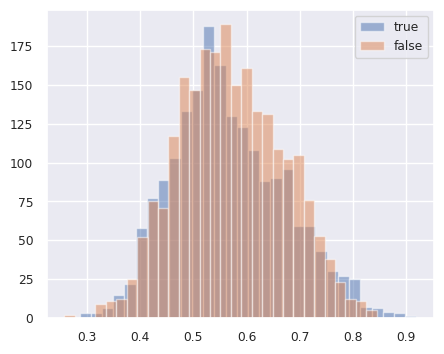

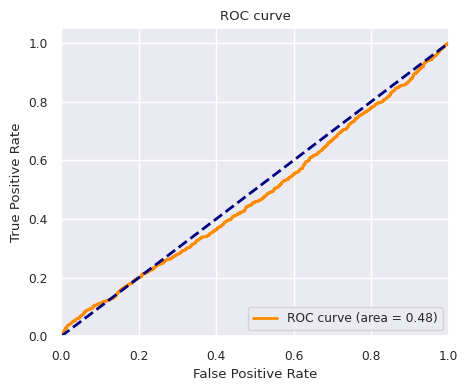


    best_threshold: 0.7268 
        
    f1: 0.1458
    accuracy: 0.5533
    precision: 0.5314
    recall: 0.0845
 

 ====================  dot product =================== 


using the given model


100%|██████████| 200/200 [00:52<00:00,  3.83it/s]


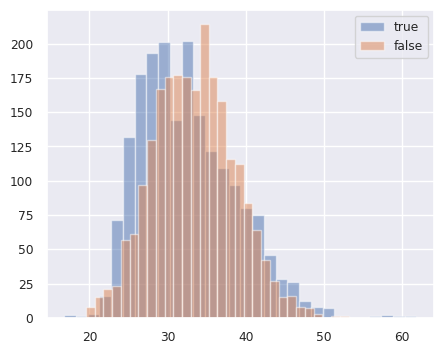

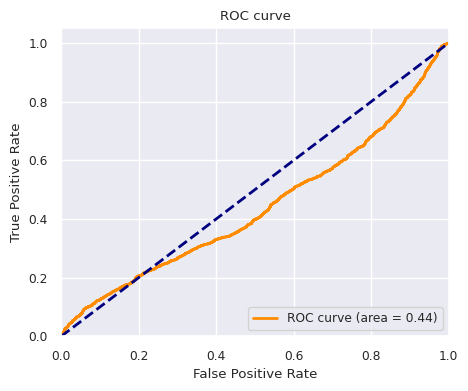


    best_threshold: 41.5277 
        
    f1: 0.1587
    accuracy: 0.5582
    precision: 0.5641
    recall: 0.0923


In [418]:
POOLING_TYPE = 'mean'

wrapped_model = Model_wrapper_to_bert(tokenizer=tokenizer,
                                       bert_model=model,
                                        device='cuda',
                                        pooling_type=POOLING_TYPE)
print(""" \n\n ====================  cosine similarity =================== \n\n""")

run_with_model(model_name = wrapped_model,
                        score_function='cosine_similarity',
                        device='cuda')

print(""" \n\n ====================  dot product =================== \n\n""")
run_with_model(model_name = wrapped_model,
                        score_function='dot_product',
                        device='cuda')

 

 ====================  cosine similarity =================== 


using the given model


  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:52<00:00,  3.83it/s]


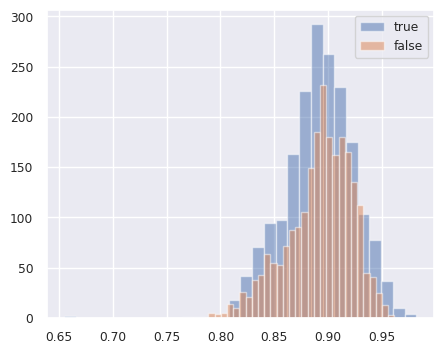

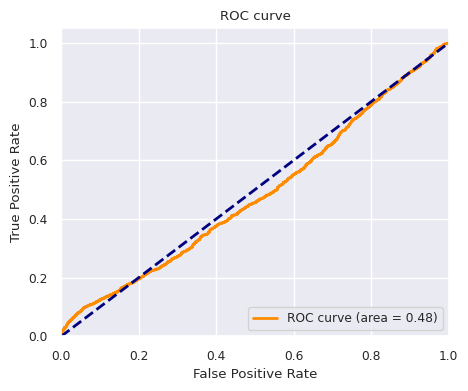


    best_threshold: 0.9319 
        
    f1: 0.167
    accuracy: 0.5606
    precision: 0.5776
    recall: 0.0976
 

 ====================  dot product =================== 


using the given model


100%|██████████| 200/200 [00:52<00:00,  3.83it/s]


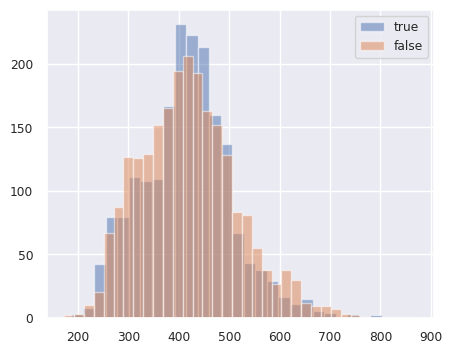

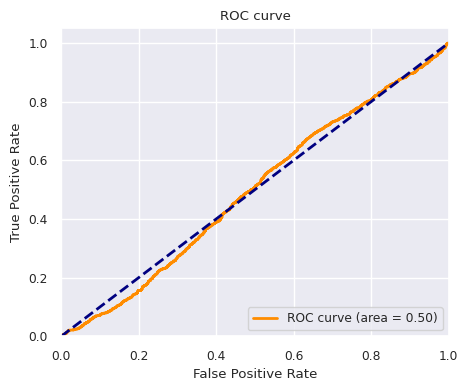


    best_threshold: 378.4333 
        
    f1: 0.5561
    accuracy: 0.5031
    precision: 0.4658
    recall: 0.6899


In [419]:
POOLING_TYPE = 'max'

wrapped_model = Model_wrapper_to_bert(tokenizer=tokenizer,
                                       bert_model=model,
                                        device='cuda',
                                        pooling_type=POOLING_TYPE)
print(""" \n\n ====================  cosine similarity =================== \n\n""")

run_with_model(model_name = wrapped_model,
                        score_function='cosine_similarity',
                        device='cuda')

print(""" \n\n ====================  dot product =================== \n\n""")
run_with_model(model_name = wrapped_model,
                        score_function='dot_product',
                        device='cuda')

 

 ====================  cosine similarity =================== 


using the given model


  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:52<00:00,  3.83it/s]


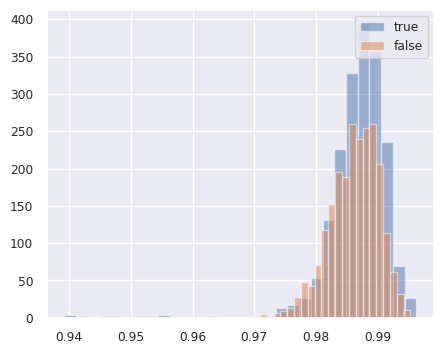

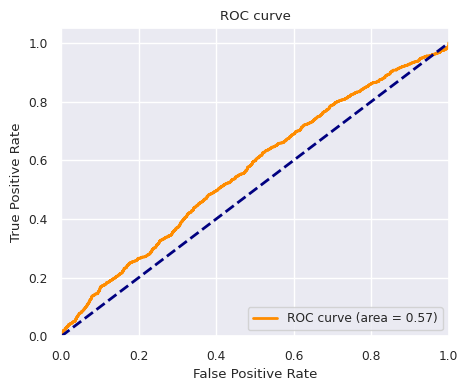


    best_threshold: 0.9863 
        
    f1: 0.5538
    accuracy: 0.5457
    precision: 0.4973
    recall: 0.6249
 

 ====================  dot product =================== 


using the given model


100%|██████████| 200/200 [00:52<00:00,  3.84it/s]


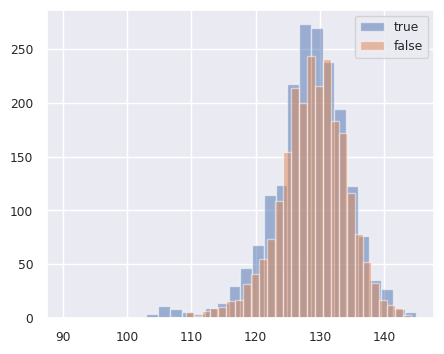

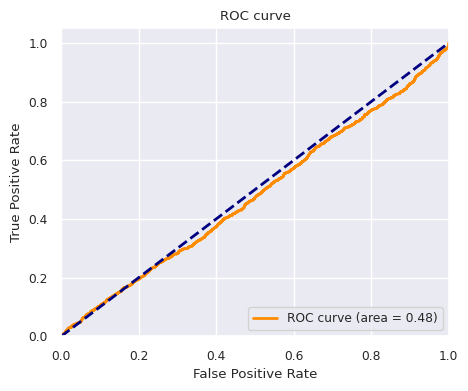


    best_threshold: 138.8851 
        
    f1: 0.0529
    accuracy: 0.5511
    precision: 0.5521
    recall: 0.0278


In [420]:
POOLING_TYPE = 'cls'

wrapped_model = Model_wrapper_to_bert(tokenizer=tokenizer,
                                       bert_model=model,
                                        device='cuda',
                                        pooling_type=POOLING_TYPE)
print(""" \n\n ====================  cosine similarity =================== \n\n""")

run_with_model(model_name = wrapped_model,
                        score_function='cosine_similarity',
                        device='cuda')

print(""" \n\n ====================  dot product =================== \n\n""")
run_with_model(model_name = wrapped_model,
                        score_function='dot_product',
                        device='cuda')

Observations: 
1. cls token is giving better results compared to max, mean

# a sample

In [423]:
dataset[2]


{'statement': 'a significant number of the participants in the secondary trial and the primary trial suffered from Enterocolitis',
 'sentences': ['Adverse Events 1:',
  '  Total: 20/167 (11.98%)',
  '  Cardiac failure acute 0/167 (0.00%)',
  '  Diarrhoea 5/167 (2.99%)',
  '  Colitis 2/167 (1.20%)',
  '  Enterocolitis 1/167 (0.60%)',
  '  Enterocolitis haemorrhagic 1/167 (0.60%)',
  '  Stomatitis 1/167 (0.60%)',
  '  Impaired healing 1/167 (0.60%)',
  '  Sudden death 1/167 (0.60%)',
  '  Postoperative wound infection 2/167 (1.20%)',
  '  Erysipelas 2/167 (1.20%)',
  '  Bacterial diarrhoea 1/167 (0.60%)',
  'Adverse Events 2:',
  '  Total: 4/167 (2.40%)',
  '  Cardiac failure acute 1/167 (0.60%)',
  '  Diarrhoea 0/167 (0.00%)',
  '  Colitis 0/167 (0.00%)',
  '  Enterocolitis 0/167 (0.00%)',
  '  Enterocolitis haemorrhagic 0/167 (0.00%)',
  '  Stomatitis 0/167 (0.00%)',
  '  Impaired healing 0/167 (0.00%)',
  '  Sudden death 0/167 (0.00%)',
  '  Postoperative wound infection 1/167 (0.60%)

<b>Some thoughts:</b> here the statement is referring to them as primary , secondary trails. so, just finding the sentence embedding individually will not give it any information whethe that particular sentence belongs to primay or secondary trail.  
so, may be it fails in all such cases.